### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 21}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 21 is here the size of the considered amino acid alphabet.


In [572]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import logomaker
from time import time
from tqdm import tqdm
from IPython.display import Audio

import importlib
import sequtils as su
print(importlib.reload(su))
import seq
print(importlib.reload(seq))
import dataset as dsg
print(importlib.reload(dsg))
import model
print(importlib.reload(model))

print(tf.__version__)

%load_ext memory_profiler

<module 'sequtils' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/sequtils.py'>
<module 'seq' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/seq.py'>
<module 'dataset' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/dataset.py'>
<module 'model' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/model.py'>
2.3.1
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [573]:
# tf.compat.v1.disable_eager_execution()

In [582]:
use_real_data = False

### Create random genomes as toy data 

In [583]:
N = 8            # number of genomes
tile_size = 334  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

#genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
#insertPatterns = ["ATGATGATG", "CCCCCCCCCCCC"]
#genomes = seq.getRandomGenomes(N, genome_sizes, insertPatterns, mutationProb=0.2, verbose=True)

genome_sizes = [[10000]] * N
                # in nucleotides
insertPatterns = ["ATGGCAAGAATTCAATCTACTGCAAATAAAGAA",
                 ] 
repeatPatterns = ['AGAGAACCTGAAGCTACTGCTGAACCTGAAAGA']
genomes, repeatTracking, insertTracking = seq.getRandomGenomes(N, genome_sizes, insertPatterns,
                                                               repeatPatterns,
                                                               mutationProb=0.0, 
                                                               repeatMultiple=range(0,1),
                                                               repeatInsert=range(10,11),
                                                               verbose=False)
print(insertTracking)

{0: {0: {'pos': [6110], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 1: {0: {'pos': [3704], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 2: {0: {'pos': [3120], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 3: {0: {'pos': [417], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 4: {0: {'pos': [652], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 5: {0: {'pos': [3010], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 6: {0: {'pos': [8119], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}, 7: {0: {'pos': [6400], 'pattern': ['ATGGCAAGAATTCAATCTACTGCAAATAAAGAA']}}}


In [584]:
def printExpectedPatterns():
    desiredPatternAA, repeatPatternAA = None, None
    if insertPatterns is not None:
        desiredPatternAA = []
        for pattern in insertPatterns:
            desiredPatternAA.extend(su.six_frame_translation(pattern))

        print("Desired:", desiredPatternAA)

    if repeatPatterns is not None:
        repeatPatternAA = []
        for pattern in repeatPatterns:
            repeatPatternAA.extend(su.six_frame_translation(pattern))

        print("Repeat:", repeatPatternAA)
        
    return desiredPatternAA, repeatPatternAA

desiredPatternAA, repeatPatternAA = printExpectedPatterns()

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


---

#### Interlude: Magic Commands

https://towardsdatascience.com/speed-up-jupyter-notebooks-20716cbe2025

`%time command` prints runtime of command  
`%prun command` profiler for command, what steps take how much time? Adds overhead  
`%memit command` peak memory usage and memory increment  
`%mprun command` memory profiling

---

In [585]:
# Load Real Data
if use_real_data:
    from Bio import SeqIO
    import os
    
    files = ['hg38.fa', 'mm10.fa', 'hetGla2.fa', 'macFas5.fa']
    genomes = [[] for _ in range(len(files))]
    seqnames = [[] for _ in range(len(files))]
    datapath = "/nas-hs/projs/seedFinding/data/20210517_flanked/subset"
    def loadRealGenomes(genomes=genomes):
        for i in range(len(files)):
            genomes[i].extend([str(seq.seq) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            seqnames[i].extend([str(seq.id) for seq in SeqIO.parse(os.path.join(datapath, files[i]), 'fasta')])
            
    %memit loadRealGenomes()
    
    # load pickled Q to safe time
    Qfile = os.path.join(datapath, "backgroundAAFreqs.pkl4")
    if not os.path.isfile(Qfile):
        print("Getting Q")
        %time Q = seq.backGroundAAFreqs(genomes, True)
        with open(Qfile, 'wb') as fh:
            pickle.dump(Q, fh, protocol=4)
            
    else:
        with open(Qfile, 'rb') as fh:
            Q = pickle.load(fh)
    
else:
    %time Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  159968.0 *
C 0.0305
K 0.0307
E 0.0314
W 0.0164
T 0.0627
G 0.0644
Y 0.0313
A 0.0619
I 0.0457
N 0.0309
V 0.0627
H 0.0315
S 0.0928
D 0.0308
F 0.0310
M 0.0161
R 0.0937
L 0.0933
P 0.0644
Q 0.0309
* 0.0468
CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 150 ms


For seedFinding data on gs3

    background freqs:  765611260.0 *
    C 0.0329
    K 0.0412
    E 0.0332
    W 0.0165
    T 0.0578
    G 0.0558
    Y 0.0334
    A 0.0510
    I 0.0546
    N 0.0361
    V 0.0578
    H 0.0321
    S 0.0929
    D 0.0280
    F 0.0406
    M 0.0172
    R 0.0710
    L 0.1039
    P 0.0558
    Q 0.0352
    * 0.0527
    CPU times: user 7min 14s, sys: 1.69 s, total: 7min 16s
    Wall time: 7min 16s

In [586]:
print(len(genomes), len(genomes[0]), len(genomes[0][0]))

8 1 10000


In [587]:
# uniform background distribution appears to be rather better
Q = np.ones(21, dtype=np.float32)/21

#### Read in the genome

In [588]:
genomes[0][0][0:100]

'CTTCTTCTACCCAAACCGTGACCGCTGGTAAGTCTCACAAACGAAACGCTAAGGACCCCATTTTGCAACGGCTCCCTGGGAGGTCCATGGACCTACTATT'

In [589]:
dsg.testGenerator(genomes, 5, tile_size, 50000)

0it [00:00, ?it/s]

[INFO] >>> Test genome lengths: [10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


2it [00:04,  2.18s/it]
0it [00:00, ?it/s]

[INFO] >>> testGenerator - restore sequences: All good


2it [00:33, 16.50s/it]

[INFO] >>> testGenerator - restore positions: All good


In [12]:
genome_sizes = [sum([len(s) for s in genome]) for genome in genomes]
batch_size = 1  # number of X to generate per batch
tiles_per_X = 13 # number of tiles per X (-> X.shape[0])
steps_per_epoch = max(1, np.mean(genome_sizes) // (batch_size*tiles_per_X*tile_size*3))
print(genome_sizes, " -> ", steps_per_epoch)

[10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]  ->  1


In [14]:
def getDataset(tiles_per_X: int = tiles_per_X,
               tile_size: int = tile_size,
               genomes = genomes,
               withPosTracking: bool = False):
    if withPosTracking:
        ds = tf.data.Dataset.from_generator(
            dsg.createBatch,
            args = (tf.constant(tiles_per_X), tf.constant(tile_size), tf.constant(genomes, dtype=tf.string), 
                    tf.constant(True)),

            # vvv used in newer versions of TF vvv
            # output_signature = (tf.TensorSpec(shape = ([batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size], 
            #                                            [batch_size, len(genomes), 2]),
            #                                   dtype = (tf.float32, tf.int32))

            # vvv deprecated in newer versions of TF vvv
            output_types = (tf.float32, tf.int32),
            output_shapes = (tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size]),
                             tf.TensorShape([tiles_per_X, len(genomes), 5]))
        )
    else:
        ds = tf.data.Dataset.from_generator(
            dsg.createBatch,
            args = (tf.constant(tiles_per_X), tf.constant(tile_size), tf.constant(genomes, dtype=tf.string), 
                    tf.constant(False)),

            # vvv used in newer versions of TF vvv
            # output_signature = (tf.TensorSpec(shape = [batch_size, len(genomes), 6, tile_size, su.aa_alphabet_size],
            #                                   dtype = tf.float32))

            # vvv deprecated in newer versions of TF vvv
            output_types = (tf.float32),
            output_shapes = (tf.TensorShape([tiles_per_X, len(genomes), 6, tile_size, su.aa_alphabet_size]))
        )
    return ds

---

#### Plot Functions

In [15]:
def plotLogo(P, idxarray = None, pScores = None, max_print=5, label="score"):
    """
    max_print  print up to this many logos
    """
    dfs = su.makeDFs(P.numpy())
    for i in range(min(P.shape[2],max_print)):
        j = idxarray[i] if idxarray is not None else i
        profile_df = dfs[j]
        logo = logomaker.Logo(profile_df, vpad=.1, width=1)
        logo.style_xticks(anchor=0, spacing=1, rotation=45)
        logo.ax.set_ylabel('information (bits)')
        logo.ax.set_title(f"Profile {j}" + (f" {label}={pScores[j]:.3f}") if pScores is not None else "")

In [16]:
# plot the training history as loss and accuracy curves
def plotHistory(history):
    loss = history['loss']
    Rmax = history['Rmax']
    Rmin = history['Rmin']
    Smax = history['Smax']
    Smin = history['Smin']
    epochs = range(1, len(loss) + 1)

    fig, ax = plt.subplots(ncols = 2, figsize = (15, 6))
    ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
    ax[0].set_title('Training loss')
    ax[0].legend()

    ax[1].plot(epochs, Rmax, 'bo', label = 'Rmax')
    ax[1].plot(epochs, Rmin, 'b+', label = 'Rmin')
    ax[1].plot(epochs, Smax, 'go', label = 'Smax')
    ax[1].plot(epochs, Smin, 'g+', label = 'Smin')
    ax[1].set_title('Training R and S')
    ax[1].legend();
    
    return fig, ax

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [17]:
U = 200 # number of profiles to train
k = 11 # length of profiles

In [ ]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, P_logit_init=None, **kwargs):
        super().__init__(**kwargs)
        # P_logit_init = tf.random.normal([k, alphabet_size, units], stddev=.5, dtype=tf.float32, seed=1)
        
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units
        self.history = {'loss': [],
                        'Rmax': [],
                        'Rmin': [],
                        'Smax': [],
                        'Smin': []}
        
        if P_logit_init is None:
            P_logit_init = self._getRandomProfiles()
        if False: # to test whether the right pattern has low loss
                P_logit_init[:,:,0:2] = -100. #-100 *np.ones([k, 21, 2], dtype=np.float32)
                P_logit_init[0,15,0] = 5 # M
                P_logit_init[1,7,0] = 5 # A
                P_logit_init[2,16,0] = 5 # R
                P_logit_init[3,8,0] = 5 # I
                P_logit_init[4,19,0] = 5 # Q
                P_logit_init[5,12,0] = 5 # S
                P_logit_init[6,4,0] = 5 # T
                P_logit_init[7,7,0] = 5 # A
                P_logit_init[8,9,0] = 5 # N
                P_logit_init[9,1,0] = 5 # K
                P_logit_init[10,2,0] = 5 # E
                # REPEATAEPER
                P_logit_init[0,16,1] = 5 # R
                P_logit_init[1,2,1] = 5 # E
                P_logit_init[2,18,1] = 5 # P
                P_logit_init[3,2,1] = 5 # E
                P_logit_init[4,7,1] = 5 # A
                P_logit_init[5,4,1] = 5 # T
                P_logit_init[6,7,1] = 5 # A
                P_logit_init[7,2,1] = 5 # E
                P_logit_init[8,18,1] = 5 # P
                P_logit_init[9,2,1] = 5 # E
                P_logit_init[10,16,1] = 5 # R
                
        self.setP_logit(P_logit_init)
        
    def _getRandomProfiles(self):
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        
        P_logit_like_Q = np.log(Q2.numpy())
        P_logit_init = P_logit_like_Q + np.random.normal(scale=4., size=[self.k, self.alphabet_size, self.units]).astype('float32')
        return P_logit_init
        
    # return for each profile the best score at any position in the dataset
    def get_profile_match_sites(self, ds, threshold, aa_tile_size, genomes, L5score: bool = False):
        # dict of dicts of dict, for each genome, map each contig to a dict that collects profile indices and positions
        #   (given that the profile matches with score above threshold for that genome, contig and position)
        sites = {}
        for batch in ds:
            assert len(batch) == 2, str(len(batch))+" -- use batch dataset with position tracking!"
            X = batch[0]        # (B, tilePerX, N, 6, tileSize, 21)
            posTrack = batch[1] # (B, tilePerX, N, 3)
            assert len(X.shape) == 6, str(X.shape)
            assert len(posTrack.shape) == 4, str(posTrack.shape)
            assert X.shape[0:3] == posTrack.shape[0:3], str(X.shape)+" != "+str(posTrack.shape)
            for b in range(X.shape[0]): # iterate samples in batch
                # get positions of best profile matches
                _, _, Z = self.call(X[b])              # (tilePerX, N, 6, T-k+1, U)
                if L5score:
                    gamma = .2
                    Z2 = tf.nn.softmax(gamma*Z, axis=0)
                    Z3 = tf.math.multiply(Z, tf.square(Z2))
                    Z = Z3
                    
                for g in range(X.shape[2]):
                    if tf.reduce_max(Z[:,g,:,:,:]) >= threshold:
                        p = tf.argmax( tf.reduce_max(Z[:,g,:,:,:], axis=[0,1,2]) ).numpy() # index of the profile with best hit
                        t = tf.argmax( tf.reduce_max(Z[:,g,:,:,p], axis=[1,2]) ).numpy()   # index of the tile with best hit
                        f = tf.argmax( tf.reduce_max(Z[t,g,:,:,p], axis=[1]) ).numpy()     # index of the frame with best hit
                        r = tf.argmax( Z[t,g,f,:,p] ).numpy()                              # index of the rel. position with best hit

                        c = posTrack[b,t,g,0].numpy()
                        if c < 0:
                            continue # either bug or profile matches good on padding
                            
                        assert c < len(genomes[g]), str(c)+" >= "+str(len(genomes[g]))+" for genome "+str(g)
                            
                        cStart = posTrack[b,t,g,1].numpy()
                        tilelen = posTrack[b,t,g,2].numpy()
                        
                        pos = r*3 # to dna coord
                        if f < 3:
                            pos += f # add frame shift
                            pos = cStart + pos
                        else:
                            # add appropriate frame shift
                            seqlen = len(genomes[g][c])
                            if seqlen%3 == tilelen%3:
                                pos += f-3
                            else:
                                pos += dsg.rcFrameOffsets(seqlen)[f-3]
                                
                            pos = tilelen - pos - (self.k*3)

                        if g not in sites:
                            sites[g] = {}
                        if c not in sites[g]:
                            sites[g][c] = {'profile': [], 'pos': [], 'score': [], 'frame': []}

                        sites[g][c]['profile'].append(p)
                        sites[g][c]['pos'].append(pos)
                        sites[g][c]['score'].append(Z[t,g,f,r,p].numpy())
                        sites[g][c]['frame'].append(f)
                        
        return sites
    
    # return index of the profile that has the highest mean score of all scores in all tiles
    def get_best_profile(self, ds):
        N = np.zeros(self.units, dtype=np.float32)
        S = np.zeros(self.units, dtype=np.float32)
        
        for batch in ds:
            assert len(batch) == 2, str(len(batch))+" -- use batch dataset with position tracking!"
            X = batch[0]        # (B, tilePerX, N, 6, tileSize, 21)
            posTrack = batch[1] # (B, tilePerX, N, 3)
            assert len(X.shape) == 6, str(X.shape)
            assert len(posTrack.shape) == 4, str(posTrack.shape)
            assert X.shape[0:3] == posTrack.shape[0:3], str(X.shape)+" != "+str(posTrack.shape)
            for b in range(X.shape[0]): # iterate samples in batch
                # get positions of best profile matches
                _, _, Z = self.call(X[b])              # Z: tilePerX, N, 6, T-k+1, U), X: (batchsize, tilePerX, N, 6, T, alphSize) 
                gamma = .2
                Z2 = tf.nn.softmax(gamma*Z, axis=0)
                Z3 = tf.math.multiply(Z, tf.square(Z2))
                Z = Z3

                for u in range(Z.shape[-1]):
                    for t in range(Z.shape[0]):
                        s = tf.reduce_max(Z[t,:,:,:,u])
                        n = tf.argmax( tf.reduce_max(Z[t,:,:,:,u], axis=[1,2]) ).numpy() # index of genome with highest score
                        if posTrack[b,t,n,0] >= 0: # otherwise contig was exhausted
                            N[u] += 1
                            S[u] += s
                            
        M = np.array([S[i]/N[i] if N[i] > 0 else -np.inf for i in range(len(N))])
        return np.argmax(M), np.max(M) # index, mean score

    def getP(self):
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def getR(self):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        # Limit the odds-ratio, to prevent problem with log(0).
        # Very bad matches of profiles are irrelevant anyways.
        ratio = tf.maximum(P/Q2, 1e-6)
        R = tf.math.log(ratio)
        return R
    
    def getZ(self, X):
        R = self.getR()

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                          padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension
        return Z, R
        
    def call(self, X):
        Z, R = self.getZ(X)

        S = tf.reduce_max(Z, axis=[2,3])
        return S, R, Z

    # custom loss
    def loss(self, S):
        # overall fit of patterns
        # beta = 5.0 # the larger the harder the softmax
        # S1 = tf.math.multiply(S, tf.nn.softmax(beta*S, axis=0)) # a soft version between maximizing and summing over the tiles
        L1 = -tf.reduce_sum(S) / self.units
        
        # homogeneity along pattern
        P = self.getP()
        H = -tf.reduce_sum(tf.math.multiply(P, tf.math.log(P)), axis=1) # entropy
        # standard deviation of entropies
        VH = tf.math.reduce_std(H, axis=0) # variance for each profile along site axis
        L2 = tf.reduce_mean(VH)
        
        # homogeneity between genomes
        # ignore the best score per genome, so that rather others are improved
        # L3 = tf.reduce_sum(tf.reduce_max(S, axis=1)) # cancels out the best occurence from L1
        
        # other ideas: 
        # - std deviation of scores of different genomes
        # L4 = tf.reduce_sum(tf.math.reduce_std(tf.reduce_max(S, axis=0), axis=0))
        # - minimum score of any genome
        
        # penalize multiple similarly good near-best matches in the same genome
        gamma = .2 # a small value means a more inclusive meaning of near-best
        S2 = tf.nn.softmax(gamma*S, axis=0)
        S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
        S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
        S5 = tf.math.multiply(S4, tf.square(S3)) # effectively the best score per genome is divided by the number of matches
        loss_by_unit = tf.reduce_sum(-S5, axis=0) / self.units # sum over genomes
        L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
        
        #return (L1+L3)/N + 50*L2, L2, L4 # + 100*L2 # (L1 + L3)/N #+ 100*L2
        return L5, loss_by_unit, (L1, L2, (L5, loss_by_unit)) # first: loss to use in training, last: tuple of all losses for evaluation

    # return for each profile the best score at any position in the dataset
    def max_profile_scores(self, ds):
        scores = np.ones([self.units], dtype=np.float32) * -np.infty
        for batch in ds:
            assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
            for X in batch:
                assert len(X.shape) == 5, str(X.shape)
                S, _, _ = self.call(X)
                scores = np.maximum(np.max(S, axis=(0,1)), scores)
                                    
        return scores
    
    # return for each profile the loss contribution
    def min_profile_losses(self, ds):
        losses = np.zeros([self.units], dtype=np.float32)
        for batch in ds:
            assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
            for X in batch:
                assert len(X.shape) == 5, str(X.shape)
                S, _, _ = self.call(X)
                _, losses_by_unit, _ = self.loss(S)
                losses += losses_by_unit
                                    
        return losses
    
    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S, R, _ = self.call(X)
            L, _, _ = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])
        
        return S, R, L

    def train(self, X, epochs=1000, verbose=True):
        self.opt = tf.keras.optimizers.Adam(learning_rate=.1) # large learning rate is much faster
        for i in range(epochs):
            self.train_step(X)
            if verbose and (i%(100) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())))
                
    def train_ds(self, ds_train, ds_eval, steps_per_epoch, epochs, verbose=True, verbose_freq=100):
        self.opt = tf.keras.optimizers.Adam(learning_rate=1.) # large learning rate is much faster
        tstart = time()
        for i in range(epochs):
            steps = 0
            Lb = []
            Smin, Smax = float('inf'), float('-inf')
            Rmin, Rmax = float('inf'), float('-inf')
            for batch in ds_train:
                assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
                for X in batch:
                    assert len(X.shape) == 5, str(X.shape)
                    S, R, L = self.train_step(X)
                    Lb.append(L)
                    Rmax = max(Rmax, tf.reduce_max(R).numpy())
                    Rmin = min(Rmin, tf.reduce_min(R).numpy())
                    Smax = max(Smax, tf.reduce_max(S).numpy())
                    Smin = min(Smin, tf.reduce_min(S).numpy())
                    
                steps += 1
                if steps >= steps_per_epoch:
                    break
                    
            p, s = self.get_best_profile(ds_eval)
            print("epoch", i, "best profile", p, "with score", s)
                    
            self.history['loss'].append(np.mean(Lb))
            self.history['Rmax'].append(Rmax)
            self.history['Rmin'].append(Rmin)
            self.history['Smax'].append(Smax)
            self.history['Smin'].append(Smin)
                    
            if verbose and (i%(verbose_freq) == 0 or i==epochs-1):
                S, R, _ = self(X)
                L, _, _ = self.loss(S)
                tnow = time()
                print(f"epoch {i:>5} loss={L.numpy():.4f}" +
                      " max R: {:.3f}".format(tf.reduce_max(R).numpy()) +
                      " min R: {:.3f}".format((tf.reduce_min(R).numpy())) +
                      " time: {:.2f}".format(tnow-tstart)) 
                
    def seed_P_ds(self, ds):
        """
            Seed profiles P with profiles that represent units random positions in the input sequences.
            Positions are drawn uniformly from all positions in all sequences. 
            This is done with an old and neat trick online, so that the data has to be read only once.
        """
        rho = 2.0
        oneProfile_logit_like_Q = np.log(self.Q)
        P_logit_init = self._getRandomProfiles() # shape [k, alphabet_size, units]
        m = 0 # number of positions seen so far
        for batch in ds:
            assert len(batch.shape) == 6, str(batch.shape)+" -- use batch dataset without position tracking!"
            for X in batch:
                assert len(X.shape) == 5, str(X.shape)
                X = X.numpy()
                PP = X.reshape([-1, self.alphabet_size]) # (tilesPerX, N, 6, T, alphSize) -> (tilesPerX*N*6*T, alphSize)
                J = PP.shape[0]
                # PP[j,a] is 1 if the j-th character in an artificially concatenated sequence is char a
                # the length k patterns extend over tile ends, which could be improved later
                num_pos = J - self.k
                for j in range(num_pos):
                    i = -1 # i-th profile is to be replaced, unless i<0
                    if m < self.units:
                        i = m
                    elif np.random.choice(m) < self.units:
                        i = np.random.choice(self.units)
                    if i >= 0:
                        # replace i-th profile with a seed profile build from the pattern starting at position j
                        # Seed is the background distribution, except the observed k-mer at pos j is more likely
                        seed = rho * PP[j:j+self.k,:] + oneProfile_logit_like_Q
                        P_logit_init[:,:,i] = seed
                        # print (f"replacing {i:>3}-th pattern with the one from pos {j:>6}:\n", seed)
                    m += 1

        return P_logit_init
    
    def seed_P_triplets(self):
        self.units = self.alphabet_size ** 3
        P_logit = np.zeros((self.k, self.alphabet_size, self.units), dtype=np.float32)
        p = 0
        for i in range(self.alphabet_size):
            for j in range(self.alphabet_size):
                for k in range(self.alphabet_size):
                    P_logit[0,:,p] = np.ones(self.alphabet_size, dtype=np.float32) * 1e-6
                    P_logit[1,:,p] = np.ones(self.alphabet_size, dtype=np.float32) * 1e-6
                    P_logit[2,:,p] = np.ones(self.alphabet_size, dtype=np.float32) * 1e-6
                    P_logit[0,i,p] = 1e6
                    P_logit[1,j,p] = 1e6
                    P_logit[2,k,p] = 1e6
                    p += 1
                    
        return P_logit
                
    def setP_logit(self, P_logit_init):
        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 

In [18]:
print(importlib.reload(model))

<module 'model' from '/nas-hs/users/matthis/genomegraph/learn_specific_profiles/model.py'>


In [19]:
# build and randomly initialize profile model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
specProModel = None
#%time %memit specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
%time %memit specProModel = model.SpecificProfile(k, su.aa_alphabet_size, U, Q)

peak memory: 325.77 MiB, increment: 8.35 MiB
CPU times: user 164 ms, sys: 56 ms, total: 220 ms
Wall time: 344 ms


In [20]:
if False:
    P_init = specProModel.getP()
    plotLogo(P_init)

### Training Set

In [21]:
ds = getDataset().repeat().batch(batch_size).prefetch(3)
ds_score = getDataset().batch(batch_size).prefetch(3)
ds_init  = getDataset().batch(batch_size).prefetch(3)

In [22]:
%time P_logit_init = specProModel.seed_P_ds(ds_init)
specProModel.setP_logit(P_logit_init)

#%time P_logit_init = specProModel.seed_P_triplets()
#print(specProModel.units)
#specProModel.setP_logit(P_logit_init)

CPU times: user 1.56 s, sys: 40 ms, total: 1.6 s
Wall time: 1.6 s


    CPU times: user 3min 56s, sys: 1.72 s, total: 3min 58s
    Wall time: 3min 55s

In [ ]:
# notebook's model
tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
%time %memit specProModel_nb = SpecificProfile(k, su.aa_alphabet_size, U, Q)

%time P_logit_init = specProModel_nb.seed_P_ds(ds_init)
#specProModel.setP_logit(P_logit_init)

### Training

    Training on seedFinding data takes 5.5 h for 10 epochs on greifserv3

In [23]:
ds_eval = getDataset(withPosTracking = True).batch(batch_size).prefetch(3)

In [24]:
start = time()
#specProModel.train_ds(ds, ds_eval, steps_per_epoch, epochs=5, verbose_freq=1)
specProModel.train(ds, ds_eval, ds_init, steps_per_epoch, epochs=50, verbose_freq=1, n_best_profiles=10)
end = time()
print(f"time: {end-start:.2f}")

epoch 0 best profile 23 with score 119.871666
epoch     0 loss=-28.1466 max R: 2.732 min R: -1.725 time: 2.14
epoch 1 best profile 23 with score 155.14612
epoch     1 loss=-51.0401 max R: 2.995 min R: -3.339 time: 2.99
epoch 2 best profile 23 with score 160.66566
epoch     2 loss=-71.2117 max R: 3.036 min R: -5.063 time: 3.88
epoch 3 best profile 23 with score 161.12991
epoch     3 loss=-87.7657 max R: 3.043 min R: -6.897 time: 4.69
epoch 4 best profile 23 with score 160.69472
epoch     4 loss=-99.4849 max R: 3.044 min R: -8.774 time: 5.54
epoch 5 best profile 23 with score 160.68762
epoch     5 loss=-107.7362 max R: 3.044 min R: -10.571 time: 6.38
epoch 6 best profile 23 with score 161.11314
cleaning up profile 23
epoch     6 loss=-5.6714 max R: 1.734 min R: -0.266 time: 8.79
epoch 7 best profile 72 with score 18.216608
epoch     7 loss=-13.4821 max R: 2.598 min R: -1.339 time: 9.64
epoch 8 best profile 72 with score 30.952036
epoch     8 loss=-23.1902 max R: 2.933 min R: -2.884 time:

epoch 73 best profile 0 with score 82.10159
epoch    73 loss=-59.3321 max R: 3.044 min R: -13.816 time: 68.49
epoch 74 best profile 0 with score 92.28685
epoch    74 loss=-67.7820 max R: 3.045 min R: -13.816 time: 69.26
epoch 75 best profile 6 with score 95.3798
epoch    75 loss=-73.5715 max R: 3.045 min R: -13.816 time: 70.13
epoch 76 best profile 6 with score 98.62629
epoch    76 loss=-77.8765 max R: 3.045 min R: -13.816 time: 70.92
epoch 77 best profile 6 with score 102.21353
epoch    77 loss=-81.4904 max R: 3.045 min R: -13.816 time: 71.78
epoch 78 best profile 6 with score 102.404594
epoch    78 loss=-84.6974 max R: 3.045 min R: -13.816 time: 72.62
epoch 79 best profile 174 with score 105.778244
epoch    79 loss=-86.9866 max R: 3.045 min R: -13.816 time: 73.41
epoch 80 best profile 174 with score 107.907265
epoch    80 loss=-88.3958 max R: 3.045 min R: -13.816 time: 74.28
epoch 81 best profile 174 with score 108.8595
epoch    81 loss=-89.5923 max R: 3.045 min R: -13.816 time: 74.9

epoch 145 best profile 53 with score 31.750925
epoch   145 loss=-21.9772 max R: 3.022 min R: -5.974 time: 131.88
epoch 146 best profile 186 with score 44.4092
epoch   146 loss=-30.3919 max R: 3.042 min R: -9.572 time: 132.71
epoch 147 best profile 2 with score 56.433403
epoch   147 loss=-38.6740 max R: 3.044 min R: -12.954 time: 133.54
epoch 148 best profile 149 with score 69.4241
epoch   148 loss=-47.3913 max R: 3.044 min R: -13.816 time: 134.34
epoch 149 best profile 149 with score 80.97393
epoch   149 loss=-55.1898 max R: 3.045 min R: -13.816 time: 135.19
epoch 150 best profile 149 with score 89.236206
epoch   150 loss=-61.4509 max R: 3.045 min R: -13.816 time: 136.05
epoch 151 best profile 149 with score 95.32029
epoch   151 loss=-66.1271 max R: 3.045 min R: -13.816 time: 136.90
epoch 152 best profile 149 with score 94.82185
epoch   152 loss=-69.3329 max R: 3.045 min R: -13.816 time: 137.68
epoch 153 best profile 149 with score 99.846634
epoch   153 loss=-71.9578 max R: 3.045 min R

epoch   216 loss=-5.3215 max R: 1.734 min R: -0.266 time: 195.02
time: 195.02


Real Data with best profile evaluation after each epoch:

    epoch 0 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(69.00166, shape=(), dtype=float32)
    epoch     0 loss=-0.9485 max R: 3.045 min R: -13.816 time: 165.04
    epoch 1 best profile tf.Tensor(9, shape=(), dtype=int64) with score tf.Tensor(69.49853, shape=(), dtype=float32)
    epoch     1 loss=-0.9942 max R: 3.045 min R: -13.816 time: 329.26
    epoch 2 best profile tf.Tensor(108, shape=(), dtype=int64) with score tf.Tensor(75.04097, shape=(), dtype=float32)
    epoch     2 loss=-0.8009 max R: 3.045 min R: -13.816 time: 492.87
    epoch 3 best profile tf.Tensor(98, shape=(), dtype=int64) with score tf.Tensor(61.438164, shape=(), dtype=float32)
    epoch     3 loss=-0.8144 max R: 3.045 min R: -13.816 time: 657.97
    epoch 4 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch     4 loss=-0.7948 max R: 3.045 min R: -13.816 time: 820.03
    epoch 5 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch     5 loss=-0.8001 max R: 3.045 min R: -13.816 time: 983.94
    epoch 6 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch     6 loss=-0.8001 max R: 3.045 min R: -13.816 time: 1146.13
    epoch 7 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch     7 loss=-0.8001 max R: 3.045 min R: -13.816 time: 1307.16
    epoch 8 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch     8 loss=-0.8001 max R: 3.045 min R: -13.816 time: 1467.12
    epoch 9 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch     9 loss=-0.8001 max R: 3.045 min R: -13.816 time: 1629.19
    epoch 10 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch    10 loss=-0.8001 max R: 3.045 min R: -13.816 time: 1792.93
    epoch 11 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch    11 loss=-0.8001 max R: 3.045 min R: -13.816 time: 1952.92
    epoch 12 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch    12 loss=-0.8001 max R: 3.045 min R: -13.816 time: 2112.31
    epoch 13 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch    13 loss=-0.8001 max R: 3.045 min R: -13.816 time: 2274.57
    epoch 14 best profile tf.Tensor(169, shape=(), dtype=int64) with score tf.Tensor(51.54927, shape=(), dtype=float32)
    epoch    14 loss=-0.8001 max R: 3.045 min R: -13.816 time: 2432.46
    time: 2432.46

(<Figure size 1080x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Training loss'}>,
        <AxesSubplot:title={'center':'Training R and S'}>], dtype=object))

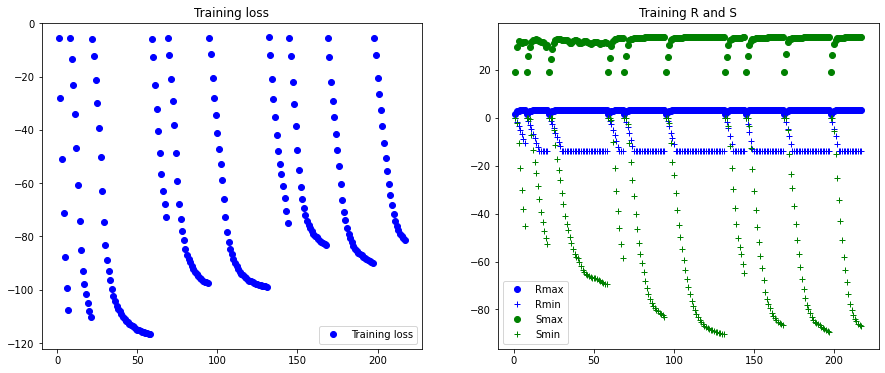

In [25]:
plotHistory(specProModel.history)

### Visualize resulting profiles as sequence logos

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


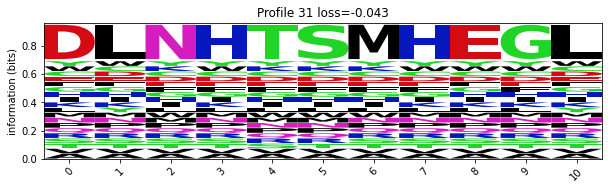

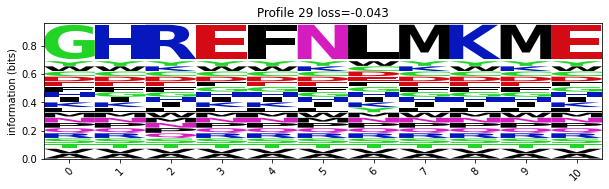

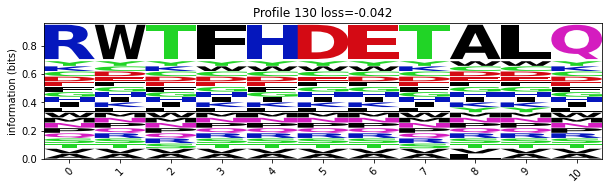

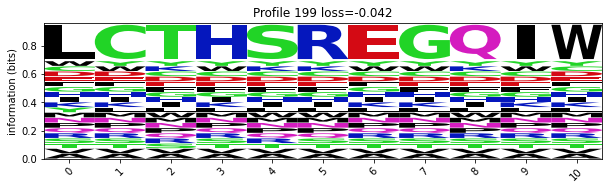

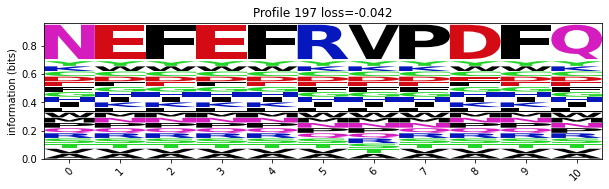

In [26]:
printExpectedPatterns()
P = specProModel.getP()
#pScores = specProModel.max_profile_scores(ds_score)
#plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=20)
pLosses = specProModel.min_profile_losses(ds_score)
plotLogo(P=P, idxarray = np.argsort(pLosses), pScores=pLosses, max_print=5, label="loss")

Desired: ['MARIQSTANKE', 'WQEFNLLQIK', 'GKNSIYCK*R', 'FFICSRLNSCH', 'SLFAVD*ILA', 'LYLQ*IEFLP']
Repeat: ['REPEATAEPER', 'ENLKLLLNLK', 'RT*SYC*T*K', 'SFRFSSSFRFS', 'LSGSAVASGS', 'FQVQQ*LQVL']


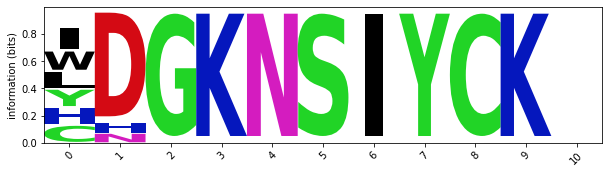

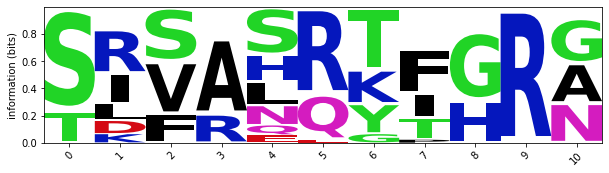

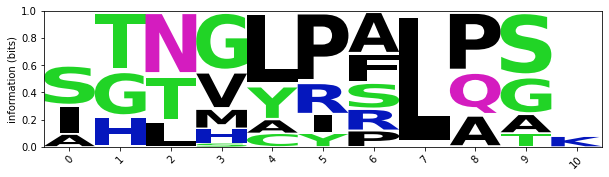

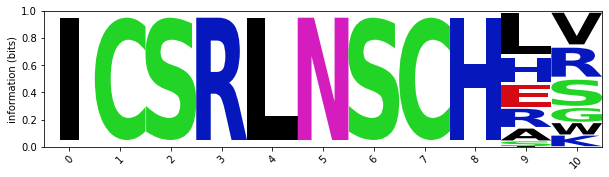

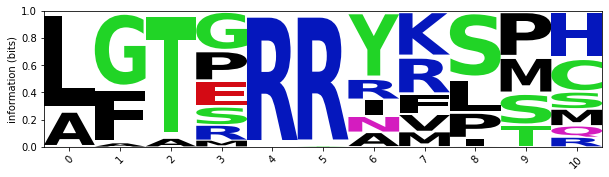

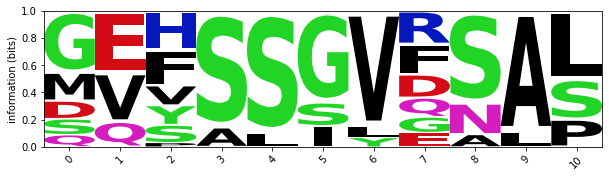

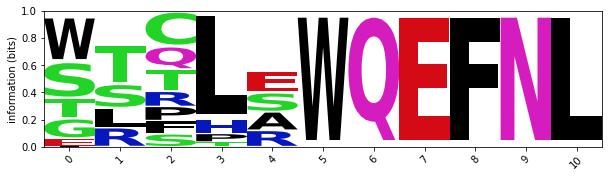

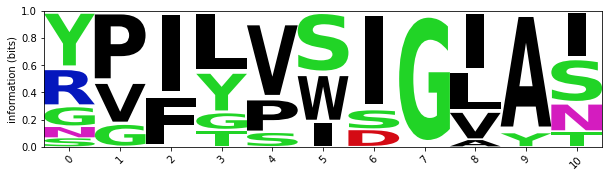

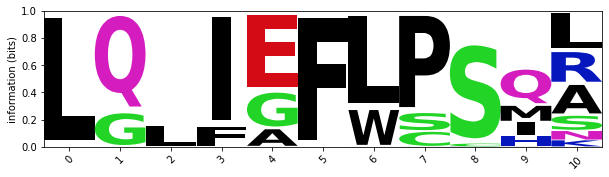

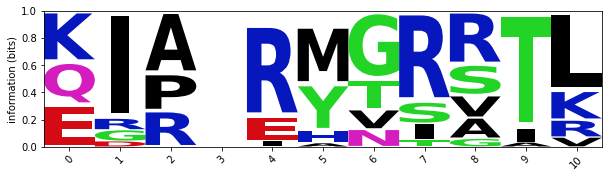

In [27]:
printExpectedPatterns()
plotLogo(P=specProModel.getP_report(), max_print=10, label="loss")

In [ ]:
pScores = specProModel.max_profile_scores(ds_score)
plotLogo(P=P, idxarray = np.argsort(-pScores), pScores=pScores, max_print=5)

---

In [39]:
def calculateMatches(tpl):
    t,m = tpl
    # shapes: z (6, T-k+1, U)
    #         t (5) -> [:,:,0] - genome IDs, [:,:,1] - contig IDs, [:,:,2] - tile start, [:,:,3] - tile size, [:,:,4] - seqlen, -1: exhausted
    #         m (6, t-k+1, U)
    #assert len(z.shape) == 3, str(z.shape)
    assert len(t.shape) == 1, str(t.shape)
    assert len(m.shape) == 3, str(m.shape)
    assert t[0] >= -1, str(t) # exhausted contigs should have been filtered out before

    sites = []
    for f in range(m.shape[0]):
        for r in range(m.shape[1]):
            for u in range(m.shape[2]):
                if m[f,r,u]:
                    genome = t[0].numpy()
                    contig = t[1].numpy()
                    assert contig < len(genomes[genome]), str(contig)+" >= "+str(len(genomes[genome]))+" for genome "+str(genome)
                    tileStart = t[1].numpy()
                    tileLen = t[2].numpy()
                    seqLen = t[3].numpy()
                    p = dsg.restoreGenomePosition(r, f, tileStart, tileLen, seqLen, k)

                    sites.append((genome, contig, p, u))

    return tf.constant(sites, dtype=tf.int32, shape=[None])

In [144]:
tf.broadcast_to([1,2,3], (2,2,2,3))

<tf.Tensor: shape=(2, 2, 2, 3), dtype=int32, numpy=
array([[[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]],


       [[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]]], dtype=int32)>

In [142]:
tf.broadcast_to(tf.range(0,200,dtype=tf.int32), (324,200))

<tf.Tensor: shape=(324, 200), dtype=int32, numpy=
array([[  0,   1,   2, ..., 197, 198, 199],
       [  0,   1,   2, ..., 197, 198, 199],
       [  0,   1,   2, ..., 197, 198, 199],
       ...,
       [  0,   1,   2, ..., 197, 198, 199],
       [  0,   1,   2, ..., 197, 198, 199],
       [  0,   1,   2, ..., 197, 198, 199]], dtype=int32)>

In [145]:
def indexTensorBC(T, N, F, P, U):
    Uidx = tf.broadcast_to(tf.range(0, U, dtype=tf.int32), (T,N,F,P,U))
    Pidx = tf.broadcast_to(tf.range(0, P, dtype=tf.int32), (T,N,F,P))
    Pidx = tf.repeat(tf.expand_dims(Pidx, -1), [U], axis=-1)
    Fidx = tf.broadcast_to(tf.range(0, F, dtype=tf.int32), (T,N,F))
    Fidx = tf.repeat(tf.expand_dims(Fidx, -1), [P], axis=-1)
    Fidx = tf.repeat(tf.expand_dims(Fidx, -1), [U], axis=-1)
    I = tf.stack((Fidx, Pidx, Uidx), axis=5)
    assert I.shape == [T,N,F,P,U,3], str(I.shape)
    return I

In [148]:
tf.reduce_all(indexTensorBC(1,2,3,10,5) == indexTensor(1,2,3,10,5))

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [123]:
def indexTensor(T, N, F, P, U):
    Uidx = tf.expand_dims(tf.range(0, U, dtype=tf.int32), 0) # (1, U)
    Uidx = tf.expand_dims(tf.repeat(Uidx, [P], axis=0), 0)   # (1, T-k+1, U)
    Uidx = tf.expand_dims(tf.repeat(Uidx, [F], axis=0), 0)   # (1, 6, T-k+1, U)
    Uidx = tf.expand_dims(tf.repeat(Uidx, [N], axis=0), 0)   # (1, N, 6, T-k+1, U)
    Uidx = tf.repeat(Uidx, [T], axis=0)                      # (tilesPerX, N, 6, T-k+1, U)
    assert Uidx.shape == [T,N,F,P,U], str(Uidx.shape)

    Pidx = tf.expand_dims(tf.range(0, P, dtype=tf.int32), -1) # (T-k+1, 1)
    Pidx = tf.expand_dims(tf.repeat(Pidx, [U], axis=-1), 0)   # (1, T-k+1, U)
    Pidx = tf.expand_dims(tf.repeat(Pidx, [F], axis=0), 0)    # (1, 6, T-k+1, U)
    Pidx = tf.expand_dims(tf.repeat(Pidx, [N], axis=0), 0)    # (1, N, 6, T-k+1, U)
    Pidx = tf.repeat(Pidx, [T], axis=0)                       # (tilesPerX, N, 6, T-k+1, U)
    assert Pidx.shape == [T,N,F,P,U], str(Pidx.shape)

    Fidx = tf.expand_dims(tf.range(0, F, dtype=tf.int32), -1) # (6, 1)
    Fidx = tf.expand_dims(tf.repeat(Fidx, [P], axis=-1), -1)  # (6, T-k+1, 1)
    Fidx = tf.expand_dims(tf.repeat(Fidx, [U], axis=-1), 0)   # (1, 6, T-k+1, U)
    Fidx = tf.expand_dims(tf.repeat(Fidx, [N], axis=0), 0)    # (1, N, 6, T-k+1, U)
    Fidx = tf.repeat(Fidx, [T], axis=0)                       # (tilesPerX, N, 6, T-k+1, U)
    assert Fidx.shape == [T,N,F,P,U], str(Fidx.shape)

    I = tf.stack((Fidx, Pidx, Uidx), axis=5)
    assert I.shape == [T,N,F,P,U,3], str(I.shape)
    return I

In [124]:
indexTensor(1,2,3,10,5)

<tf.Tensor: shape=(1, 2, 3, 10, 5, 3), dtype=int32, numpy=
array([[[[[[0, 0, 0],
           [0, 0, 1],
           [0, 0, 2],
           [0, 0, 3],
           [0, 0, 4]],

          [[0, 1, 0],
           [0, 1, 1],
           [0, 1, 2],
           [0, 1, 3],
           [0, 1, 4]],

          [[0, 2, 0],
           [0, 2, 1],
           [0, 2, 2],
           [0, 2, 3],
           [0, 2, 4]],

          [[0, 3, 0],
           [0, 3, 1],
           [0, 3, 2],
           [0, 3, 3],
           [0, 3, 4]],

          [[0, 4, 0],
           [0, 4, 1],
           [0, 4, 2],
           [0, 4, 3],
           [0, 4, 4]],

          [[0, 5, 0],
           [0, 5, 1],
           [0, 5, 2],
           [0, 5, 3],
           [0, 5, 4]],

          [[0, 6, 0],
           [0, 6, 1],
           [0, 6, 2],
           [0, 6, 3],
           [0, 6, 4]],

          [[0, 7, 0],
           [0, 7, 1],
           [0, 7, 2],
           [0, 7, 3],
           [0, 7, 4]],

          [[0, 8, 0],
           [0, 8, 1],
 

In [158]:
Tbc = tf.repeat(tf.expand_dims(T, 1), [M.shape[-1]], axis=1)
Tbc = tf.repeat(tf.expand_dims(Tbc, 1), [M.shape[-2]], axis=1)
Tbc = tf.repeat(tf.expand_dims(Tbc, 1), [M.shape[-3]], axis=1)
Tbc

<tf.Tensor: shape=(80, 6, 324, 200, 5), dtype=int32, numpy=
array([[[[[    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          ...,
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000]],

         [[    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          ...,
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000]],

         [[    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          ...,
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000],
          [    0,     0,     0,  1002, 10000]],

         ...,

         [[    0,     0,    

In [164]:
tf.concat((sites, pTracks), axis=1)

<tf.Tensor: shape=(3273086, 8), dtype=int32, numpy=
array([[    0,     0,    30, ...,     0,  1002, 10000],
       [    0,     0,    40, ...,     0,  1002, 10000],
       [    0,     0,    47, ...,     0,  1002, 10000],
       ...,
       [    5,   323,   171, ...,  9018,   982, 10000],
       [    5,   323,   180, ...,  9018,   982, 10000],
       [    5,   323,   191, ...,  9018,   982, 10000]], dtype=int32)>

In [208]:
@tf.function
def rcFrameOffsets(seqlen):
    sm3 = tf.math.mod(seqlen, 3)
    if tf.equal(sm3, 0):
        return tf.constant([2,0,1])
    elif tf.equal(sm3, 1):
        return tf.constant([1,2,0])
    else:
        return tf.constant([0,1,2])

@tf.function()
def restoreGenomePosition(aaTilePos, frame, tileStart, tileLen, seqLen, k):
    #assert frame in range(6), str(frame)+" must be in [0,5]"
    p = tf.math.multiply(aaTilePos, 3) # to dna coord
    if tf.less(frame, 3):
        p += frame     # add frame shift
        p += tileStart # add tile start to get absolute position
    else:
        # add appropriate frame shift
        if tf.equal(tf.math.mod(seqLen, 3), tf.math.mod(tileLen, 3)):
            p += tf.math.subtract(frame, 3)
        else:
            p += rcFrameOffsets(seqLen)[frame-3]

        p = tf.math.subtract(tileLen, tf.math.subtract(p, tf.math.multiply(k, 3)))

    return p

@tf.function
def convertToPos(match): # (f, p, u, genomeID, contigID, tileStart, tileLen, seqLen)
    f = match[0]#.numpy()
    r = match[1]#.numpy()
    u = match[2]#.numpy()
    g = match[3]#.numpy()
    c = match[4]#.numpy()
    ts = match[5]#.numpy()
    tl = match[6]#.numpy()
    sl = match[7]#.numpy()
    p = tf.py_function(dsg.restoreGenomePosition, 
                       (r, f, ts, tl, sl, k), tf.int32)
    return tf.convert_to_tensor([g, c, p, u], dtype=tf.int32)

In [213]:
@tf.function
def callMap(convertToPos, matches):
     return tf.map_fn(convertToPos, matches, parallel_iterations=os.cpu_count())

In [214]:
gamma = .2
for X_b, posTrack_b in ds_eval:
    for b in range(X_b.shape[0]):
        X = X_b[b]
        posTrack = posTrack_b[b]
        print("      X", X.shape)
        print("posTrac", posTrack.shape)        
        _, _, Z = specProModel.call(X) # (tilePerX, N, 6, T-k+1, U)
        print("      Z", Z.shape)
        Z2 = tf.nn.softmax(gamma*Z, axis=0)
        Z3 = tf.math.multiply(Z, tf.square(Z2))
        
        # use with match mask to get tile indices
        Pidx = indexTensorBC(Z.shape[0], Z.shape[1], Z.shape[2], 
                             Z.shape[3], Z.shape[4])                                  # (tilePerX, N, 6, T-k+1, U, 3)
        print("   Tidx", Tidx.shape)
        
        Z = tf.reshape(Z3, [-1, Z3.shape[-3], Z3.shape[-2], Z3.shape[-1]])            # (tilesPerX*N, 6, T-k+1, U)
        M = tf.greater_equal(Z, 0.001) # consider match if score >= avg. profile score, (tilesPerX*N, 6, T-k+1, U)
        T = tf.reshape(posTrack, [-1, 5])                                             # (tilesPerX*N, 5)
        Pidx = tf.reshape(Pidx, [-1, Pidx.shape[-4], Pidx.shape[-3], 
                                     Pidx.shape[-2], Pidx.shape[-1]])                 # (tilesPerX*N, 6, T-k+1, U, 3)
        print("   M", M.shape)
        print("   T", T.shape)
        print("Pidx", Pidx.shape)
        
        # reduce to genome tiles that have matches
        Mgentile = tf.reduce_any(M, axis=[1,2,3]) # (tilesPerX*N), of which `matches` are True
        Mgentile = tf.logical_and(Mgentile, tf.not_equal(T[:,0], -1)) # also set exhausted contigs to False
        T = tf.boolean_mask(T,Mgentile)           # (matches, 5)
        M = tf.boolean_mask(M,Mgentile)           # (matches, 6, T-k+1, U)
        Pidx = tf.boolean_mask(Pidx, Mgentile)    # (matches, 6, T-k+1, U, 3)
        print("   M", M.shape)
        print("   T", T.shape)
        print("Pidx", Pidx.shape)
        
        # manual broadcast of T to the correct shape
        Tbc = tf.repeat(tf.expand_dims(T, 1), [M.shape[-1]], axis=1)
        Tbc = tf.repeat(tf.expand_dims(Tbc, 1), [M.shape[-2]], axis=1)
        Tbc = tf.repeat(tf.expand_dims(Tbc, 1), [M.shape[-3]], axis=1)
        
        sites = tf.boolean_mask(Pidx, M)  # (sites, (f, p, u))
        pTracks = tf.boolean_mask(Tbc, M) # (sites, (genomeID, contigID, tileStart, tileLen, seqLen))
        
        # (sites, (f, p, u, genomeID, contigID, tileStart, tileLen, seqLen))
        matches = tf.concat((sites, pTracks), axis=1)
        print(sites)
        print(pTracks)
        print(matches)
        
        #%time final = callMap(convertToPos, matches)
        #print(final)
        
        fwdMask = tf.less(pComplete[:,0], 3)
        
        break
    break

      X (13, 8, 6, 334, 21)
posTrac (13, 8, 5)
      Z (13, 8, 6, 324, 200)
   Tidx (80, 6, 324, 200, 3)
   M (104, 6, 324, 200)
   T (104, 5)
Pidx (104, 6, 324, 200, 3)
   M (80, 6, 324, 200)
   T (80, 5)
Pidx (80, 6, 324, 200, 3)
tf.Tensor(
[[  0   0  30]
 [  0   0  40]
 [  0   0  47]
 ...
 [  5 323 171]
 [  5 323 180]
 [  5 323 191]], shape=(3273086, 3), dtype=int32)
tf.Tensor(
[[    0     0     0  1002 10000]
 [    0     0     0  1002 10000]
 [    0     0     0  1002 10000]
 ...
 [    7     0  9018   982 10000]
 [    7     0  9018   982 10000]
 [    7     0  9018   982 10000]], shape=(3273086, 5), dtype=int32)
tf.Tensor(
[[    0     0    30 ...     0  1002 10000]
 [    0     0    40 ...     0  1002 10000]
 [    0     0    47 ...     0  1002 10000]
 ...
 [    5   323   171 ...  9018   982 10000]
 [    5   323   180 ...  9018   982 10000]
 [    5   323   191 ...  9018   982 10000]], shape=(3273086, 8), dtype=int32)
CPU times: user 33min 4s, sys: 1min 38s, total: 34min 43s
Wall time: 

In [222]:
fwdMask = tf.less(matches[:,0], 3)
rFwd = tf.boolean_mask(matches, fwdMask)
posFwd = tf.multiply(rFwd[:,1], 3)
posFwd = tf.add(posFwd, rFwd[:,0])
posFwd = tf.add(posFwd, rFwd[:,5])
posFwd

<tf.Tensor: shape=(1640868,), dtype=int32, numpy=array([   0,    0,    0, ..., 9989, 9989, 9989], dtype=int32)>

In [140]:
tf.boolean_mask(Tidx, M)

<tf.Tensor: shape=(3273086, 3), dtype=int32, numpy=
array([[  0,   0,  30],
       [  0,   0,  40],
       [  0,   0,  47],
       ...,
       [  5, 323, 171],
       [  5, 323, 180],
       [  5, 323, 191]], dtype=int32)>

---

## Profile Score Distribution

In [ ]:
def customHist(distType: str, prec = 1):
    validDistTypes = ['score', 'loss', 'L5score']
    assert distType in validDistTypes, "distType must be one of "+str(validDistTypes)
    
    collect = {}
    ds_score = getDataset().batch(batch_size).prefetch(3)
    for batch in ds_score:
        for X in batch:
            S, _, _ = specProModel(X)
            if distType == 'score':
                for s in np.array(S).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
            if distType == 'loss':
                _, LpU, _ = specProModel.loss(S)
                for l in LpU:
                    loss = np.math.floor(l*prec)
                    if loss not in collect:
                        collect[loss] = 0
                        
                    collect[loss] += 1
                    
            if distType == 'L5score':
                gamma = .2
                S2 = tf.nn.softmax(gamma*S, axis=0)
                S3 = tf.math.multiply(S, tf.square(S2))
                for s in np.array(S3).flatten():
                    score = np.math.floor(s*prec)
                    if score not in collect:
                        collect[score] = 0
                        
                    collect[score] += 1
                    
    fkeys = [k for k in collect.keys()]
    bins = [b for b in range(min(fkeys), max(fkeys)+1)]
    vals = [collect[k] if k in collect else 0 for k in bins]
    bins = [b/prec for b in bins]
    
    plt.bar(list(range(len(bins))), vals, tick_label=[str(b) for b in bins])
    
    return bins, vals

In [ ]:
bins, vals = customHist('L5score', 0.5)

In [ ]:
bins, vals = customHist('loss', 100)

In [ ]:
bins, vals = customHist('score', 0.1)

     P:     (k, alphSize, U) 
     X:     (tilesPerX, N, 6, T, alphSize) 
     Z:     (tilesPerX, N, 6, T-k+1, U)
     S:     (tilesPerX, N, U)

In [ ]:
Scollect = []
Lcollect = []

if not use_real_data:
    ds_score = getDataset().batch(batch_size).prefetch(150)
    for batch in ds_score:
        for X in batch:
            S, _, Z = specProModel(X)
            _, LpU, _ = specProModel.loss(S)
            Scollect.extend(np.array(S).flatten())
            Lcollect.extend(np.array(LpU).flatten())

In [ ]:
plt.hist(Scollect)

In [ ]:
plt.hist(Lcollect)

In [ ]:
if not use_real_data:
    gamma = .01 # a small value means a more inclusive meaning of near-best
    S2 = tf.nn.softmax(gamma*S, axis=0)
    S3 = tf.reduce_max(S2, axis=0) # the closer to 1, the clearer is the champion match a winner
    S4 = tf.reduce_max(S, axis=0) # ranges over tiles, or soft max like in L1
    S5 = tf.math.multiply(S4, S3) # effectively the best score per genome is divided by the number of matches
    loss_by_unit = tf.reduce_sum(S5, axis=0) / U # sum over genomes
    L5 = tf.reduce_sum(loss_by_unit) # sum over profiles=units
    plt.hist(S4[:,0].numpy().flatten(), bins=20)
    S5.shape

---

### Profile Match Sites

In [ ]:
ds_sites = getDataset(withPosTracking = True).batch(batch_size).prefetch(3)
sites = specProModel.get_profile_match_sites(ds_sites, 0, tile_size, genomes, False)
sites

In [ ]:
import itertools

def sitesToLinks(sites):
    links = []
    profileToOcc = {}
    linkProfiles = set()
    for g in sites:
        for s in sites[g]:
            for i in range(len(sites[g][s]['profile'])):
                p = sites[g][s]['profile'][i]
                if p not in profileToOcc:
                    profileToOcc[p] = {}
                    
                if g not in profileToOcc[p]:
                    profileToOcc[p][g] = []
                    
                profileToOcc[p][g].append((g, s, sites[g][s]['pos'][i], sites[g][s]['score'][i], sites[g][s]['frame'][i]))
                
    for p in profileToOcc:
        if (len(profileToOcc[p].keys()) == 1) or (0 not in profileToOcc[p]):
            continue
            
        occs = []
        for g in profileToOcc[p]:
            occs.append(profileToOcc[p][g])
            
        l = itertools.product(*occs)
        links.extend(l)
        linkProfiles.add(p)
    
    return links, linkProfiles

links, linkProfiles = sitesToLinks(sites)
print(links[:5])
print(linkProfiles)

In [ ]:
len(links)

In [ ]:
print(insertTracking)

#### Visualize Profile Matches

In [ ]:
maxplot = 4
nplot = 0
P = specProModel.getP()
for g in list(sites.keys()):
    for c in list(sites[g].keys()):
        gseq = genomes[g][c]
        for i in range(len(sites[g][c]['profile'])):
            p = sites[g][c]['profile'][i]
            pos = sites[g][c]['pos'][i]
            score = sites[g][c]['score'][i]
            f = sites[g][c]['frame'][i]
            
            match = gseq[pos:(pos+specProModel.k*3)+2]
            match_aa = su.six_frame_translation(match)
            profile_df = su.makeDFs(P[:,:,p:(p+1)].numpy())[0]
            logo = logomaker.Logo(profile_df, vpad=.1, width=1)
            logo.style_xticks(anchor=0, spacing=1, rotation=45)
            logo.ax.set_ylabel('information (bits)')
            logo.ax.set_title(f"Profile {p}" + (f" score={score:.1f}") + " | sequence match (frame "+str(f)+") "+', '.join(match_aa))
            
            nplot += 1
            if nplot >= maxplot:
                break
                
        if nplot >= maxplot:
            break
            
    if nplot >= maxplot:
        break

In [ ]:
_, _ = printExpectedPatterns()

#### "Sensitivity" of Profile Matches

In [ ]:
def parseSequenceHeader(header):
    fields = header.split("|")
    headDict = {}
    for field in fields:
        key, value = field.split(":")
        assert len(field.split(":")) == 2, header
        assert key not in headDict, header
        headDict[key] = value

    return headDict

In [ ]:
with open(os.path.join(datapath, "../hg38.GTF.json"), 'rt') as fh:
    gtf = json.load(fh)
    
gtf['ENST00000219797']

In [ ]:
with open(os.path.join(datapath, "../orthologs.json"), 'rt') as fh:
    orthology = json.load(fh)
    
orthology

In [ ]:
seqnames[0][0:2]

In [ ]:
nexons = 0
northo = 0
for seq in seqnames[0]:
    seqDict = parseSequenceHeader(seq)
    if seqDict['tid'] != 'artificial':
        northo += 1
    if seqDict['tid'] in gtf:
        nexons += len([1 for annot in gtf[seqDict['tid']] if annot['feature'] == 'CDS'])
        
print(nexons)
print(northo)

In [ ]:
tolerance = 3*k + 3 # allow certain position mismatch in human exons
tp = [] # accumulate scores
fp = []
noise = []
geneNoise = []
exonsFound = set()
featuresFound = set()
orthoFound = set()
for link in links:
    allArt = True
    allGen = True
    for occ in link:
        #print("DEBUG", occ)
        seqname = seqnames[occ[0]][occ[1]]
        seqDict = parseSequenceHeader(seqname)
        if seqDict['gid'] == 'artificial':
            allGen = False
        else:
            allArt = False
            
    mscore = np.mean([o[3] for o in link])
    if allArt:
        fp.append(mscore)
    elif not (allArt or allGen):
        noise.append(mscore)
    else:
        assert allGen
        rSeq = seqnames[link[0][0]][link[0][1]]
        assert rSeq in orthology, rSeq
        if all([seqnames[o[0]][o[1]] in orthology[rSeq] for o in link[1:]]):
            tp.append(mscore)
            orthoFound.add(rSeq)
            seqDict = parseSequenceHeader(rSeq)
            tid = seqDict['tid']
            pos = link[0][2]
            if tid in gtf:
                for feature in gtf[tid]:
                    if feature['rstart']-tolerance <= pos and pos <= feature['rend']+tolerance:
                        featuresFound.add(str(feature))
                        if feature['feature'] == 'CDS':
                            exonsFound.add(feature['tag'])
                    else:
                        print("[DEBUG]", pos, "not in", feature['rstart'], feature['rend'], "(", feature['feature'],")")
        else:
            geneNoise.append(mscore)

In [ ]:
print("TP:", len(tp), "| mean score:", sum(tp)/len(tp) if len(tp) > 0 else 0)
print("FP:", len(fp), "| mean score:", sum(fp)/len(fp) if len(fp) > 0 else 0)
print("noise:", len(noise), "| mean score:", sum(noise)/len(noise) if len(noise) > 0 else 0)
print("geneNoise:", len(geneNoise), "| mean score:", sum(geneNoise)/len(geneNoise) if len(geneNoise) > 0 else 0)

print("Sn:", len(exonsFound), "/", nexons, "=", len(exonsFound)/nexons)
print("hits:", len(orthoFound), "/", northo, "=", len(orthoFound)/northo)

In [ ]:
for f in featuresFound:
    print(f)

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=tp, name="TP", histnorm='probability'))
fig.add_trace(go.Histogram(x=fp, name="FP", histnorm='probability'))
fig.add_trace(go.Histogram(x=noise, name="noise", histnorm='probability'))
fig.add_trace(go.Histogram(x=geneNoise, name="geneNoise", histnorm='probability'))

# Overlay both histograms and reduce opacity to see both histograms
#fig.update_layout(barmode='overlay')
#fig.update_traces(opacity=0.75)
fig.show()

In [ ]:
assert False # stop here

In [ ]:
Q

In [ ]:
str(P[:,:,0][0].numpy())

In [ ]:
def profileToMEME(p, Q, i):
    assert p.shape[1] == len(Q), str(p.shape)+", "+str(len(Q))
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    
    text = 'MEME version 4\n'
    text += 'ALPHABET "extProtein" PROTEIN-LIKE\n'
    for aa in su.aa_alphabet[1:]:
        text += aa+"\n"
        
    text += 'END ALPHABET\n'
    text += "Background letter frequencies\n"
    freq = " ".join([su.aa_alphabet[i+1]+" "+str(Q[i]) for i in range(len(Q))])
    text += freq+"\n"
    text += "MOTIF "+str(i)+" "+str(i)+"\n"
    text += "letter-probability matrix: alength= "+str(p.shape[1])+" w= "+str(p.shape[0])+"\n"
    


    AC  MA0001.1
    XX
    ID  AGL3
    XX
    DE  MA0001.1 AGL3; from JASPAR
    PO       A     C     G     T
    1        0    94     1     2
    2        3    75     0    19
    3       79     4     3    11
    4       40     3     4    50
    5       66     1     1    29
    6       48     2     0    47
    7       65     5     5    22
    8       11     2     3    81
    9       65     3    28     1
    10       0     3    88     6
    XX
    CC  program: jaspar
    XX
    //

In [ ]:
def profileToTransfac(p, i):
    assert p.shape[1] == len(su.aa_alphabet[1:]), str(p.shape)+", "+str(len(su.aa_alphabet[1:]))
    text = "AC  "+str(i)+"\n"
    text += "XX\n"
    text += "ID  "+str(i)+"\n"
    text += "XX\n"
    text += "DE  "+str(i)+"\n"
    text += "PO  "+(" ".join([su.aa_alphabet[i+1] for i in range(len(Q))]))+"\n"
    for i in range(p.shape[0]):
        text += str(i+1)+"  "+(" ".join(str(v) for v in p.numpy()[i]))+"\n"
        
    text += "XX\n"
    text += "CC  program: own\n"
    text += "//"
    return text

In [ ]:
print(profileToTransfac(P[:,:,0], 0))

In [ ]:
with open("/nas-hs/users/matthis/genomegraph/testProfileTransfacOutput.txt", 'wt') as fh:
    for i in range(P.shape[2]):
        fh.write(profileToTransfac(P[:,:,i], i))

In [ ]:
def cosineSim(a: np.ndarray, b: np.ndarray):
    assert len(a) == len(b)
    return np.sum(a*b) / (np.sqrt(np.sum(np.square(a))) * np.sqrt(np.sum(np.square(b))))

In [ ]:
cosineSim(np.array([0,1,0,0]), np.array([1,0,0,0]))

In [ ]:
# modified version of https://gist.github.com/nornagon/6326a643fc30339ece3021013ed9b48c
# enforce gapless alignment
def smith_waterman(a, b) -> float:
    assert a.shape[1] == b.shape[1], str(a.shape)+", "+str(b.shape)
    # H holds the alignment score at each point, computed incrementally
    H = np.zeros((a.shape[0] + 1, b.shape[0] + 1))
    for i in range(1, a.shape[0] + 1):
        for j in range(1, b.shape[0] + 1):
            # The score for substituting the letter a[i-1] for b[j-1]. Generally low
            # for mismatch, high for match.
            H[i,j] = H[i-1,j-1] + cosineSim(a[i-1], b[j-1])
    # The highest score is the best local alignment.
    # For our purposes, we don't actually care _what_ the alignment was, just how
    # aligned the two strings were.
    return H.max()

In [ ]:
def profileLogo(i, title="", P=P):
    profile_df = su.makeDFs(P[:,:,i:(i+1)].numpy())[0]
    logo = logomaker.Logo(profile_df, vpad=.1, width=1)
    logo.style_xticks(anchor=0, spacing=1, rotation=45)
    logo.ax.set_ylabel('information (bits)')
    logo.ax.set_title(title)

In [ ]:
a = P[:,:,0]
profileLogo(0, "Reference profile")

for i in range(5653,5658):
    b = P[:,:,i]
    s = smith_waterman(a,b)
    profileLogo(i, "Aligning with score "+str(s))

In [ ]:
for i in range(P.shape[2]):
    for j in range(i+1, P.shape[2]):
        if smith_waterman(P[:,:,i], P[:,:,j]) >= P.shape[0]/2:
            print("Similar:",i,"and",j)
            profileLogo(i,str(i))
            profileLogo(j,str(j))

---

## Find Best Profiles

Idea: 
* convert profiles into aa-sequences (translate max. values into aa at each position)
* align (or perfect match?) sequences against the 6 possible pattern translations and the insert translations
* alignment scores give an idea of how good the profiles are -> allows multiple training runs to account for randomness, evaluate how good the profiles usually are (+ variance)

In [ ]:
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

In [ ]:
def runTraining():
    tf.keras.backend.clear_session() # avoid memory cluttering by remains of old models
    
    # build and randomly initialize profile model
    specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)
    
    #start = time()
    specProModel.train_ds(ds, steps_per_epoch, epochs=500, verbose=False)
    #end = time()
    #print(f"time: {end-start:.2f}")
    
    #S, R = specProModel(X)
    #_, (L1, L2, L4, L7) = specProModel.loss(S)
    #pScores = tf.reduce_sum(tf.reduce_max(S,axis=0), axis=0).numpy()
    #print("pScores", pScores)
    #np.argsort(pScores)
    #print ("loss=", L1.numpy(), "\tL2=", L2.numpy(), 
    #       "\tL4=", L4.numpy(), "\nS=", S.numpy())
    
    P = specProModel.getP()
    
    return P

In [ ]:
def aaFromProfiles(P):
    profiles_aa = []
    for pidx in range(P.shape[2]):
        pmat = P[:,:,pidx]
        profiles_aa.append(su.to_aa_seq(pmat))

    return profiles_aa

In [ ]:
def getBestAlignments(profiles, patterns, scoreThreshold = int(k/2)):
    scores = []
    alignments = []
    best_profiles = []
    for profile in profiles:
        pscores = []
        palignments = []
        for pattern in patterns:
            als = pairwise2.align.localxd(profile, pattern, openA=-1000, extendA=-1000, openB=-1000, extendB=-1000)
            s = [al.score for al in als]
            if len(s) > 0:
                pscores.append(np.argmax(s))
                palignments.append(als[np.argmax(s)])

        best_al = palignments[np.argmax(pscores)]
        if best_al.score >= scoreThreshold:
            scores.append(best_al.score)
            alignments.append(best_al)
            best_profiles.append(profile)

    if len(scores) > 0:
        sortedIdx = np.argsort([-s for s in scores])
        scores = [scores[i] for i in sortedIdx]
        alignments = [alignments[i] for i in sortedIdx]
        best_profiles = [best_profiles[i] for i in sortedIdx]
    
    return scores, alignments, best_profiles

In [ ]:
if False:
    for i in range(20):
        P = runTraining()
        profiles = aaFromProfiles(P)
        print("Run", i)
        if insertPatterns is not None:
            print("Desired profiles:")
            patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA)
            for i in range(len(patternScores)):
                    print(patternProfiles[i])
                    print(format_alignment(*(patternAlignments[i])))

        if repeatPatterns is not None:
            print("Undesired profiles:")
            repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA)
            for i in range(len(repeatScores)):
                    print(repeatProfiles[i])
                    print(format_alignment(*(repeatAlignments[i])))

        print("")
        print("-----")
        print("")
        
else:
    P = specProModel.getP()
    profiles = aaFromProfiles(P)

    if insertPatterns is not None:
        print("Desired profiles:")
        patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
        for i in range(len(patternScores)):
                print(patternProfiles[i])
                print(format_alignment(*(patternAlignments[i])))

    if repeatPatterns is not None:
        print("Undesired profiles:")
        repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
        for i in range(len(repeatScores)):
            print(repeatProfiles[i])
            print(format_alignment(*(repeatAlignments[i])))

In [ ]:
R = specProModel.getR()
profiles = aaFromProfiles(R)
if insertPatterns is not None:
    print("Desired profiles:")
    patternScores, patternAlignments, patternProfiles = getBestAlignments(profiles, desiredPatternAA, scoreThreshold=4)
    for i in range(len(patternScores)):
            print(patternProfiles[i])
            print(format_alignment(*(patternAlignments[i])))

if repeatPatterns is not None:
    print("Undesired profiles:")
    repeatScores, repeatAlignments, repeatProfiles = getBestAlignments(profiles, repeatPatternAA, scoreThreshold=4)
    for i in range(len(repeatScores)):
        print(repeatProfiles[i])
        print(format_alignment(*(repeatAlignments[i])))

---

### Evaluate Parameter Grid

In [ ]:
from datetime import time, datetime
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
dfN = pd.read_csv("20211111_evaluate_gensize_N.csv")
dfGS = pd.read_csv("20211111_evaluate_gensize_GS.csv")
dfNS = pd.read_csv("20211111_evaluate_gensize_NS.csv")
print(dfN)
print(dfGS)
print(dfNS)

In [ ]:
def timeFromStr(tstr: str):
    h,m,s = tstr.split(":")
    s, us = s.split(".")
    us = float("0."+us) * 1000000
    #print(h,m,s,us)
    return time(int(h),int(m),int(s), int(us))

def secondsFromStr(tstr: str):
    h,m,s = tstr.split(":")
    seconds = (int(h)*60*60) + (int(m)*60) + float(s)
    return seconds
    
runtime = [secondsFromStr(s) for s in df['runtime']]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=runtime, name="runtime"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='runtime [s]')#, type='log')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=df['U'], y=df['memory'], name="memory [MB]"))
fig.update_xaxes(title_text='U')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
gsN = []
for _, row in dfN.iterrows():
    gsN.append(int(row['N']) * int(row['genome-sizes']))
    
gsGS = []
for _, row in dfGS.iterrows():
    gsGS.append(int(row['N']) * int(row['genome-sizes']))
    
gsNS = []
for _, row in dfNS.iterrows():
    gs = [int(s) for s in row['genome-sizes'].split()]
    gsNS.append(int(row['N']) * sum(gs))

fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=[secondsFromStr(s) for s in dfN['runtime']], name="runtime N"))
fig.add_trace(go.Scatter(x=gsGS, y=[secondsFromStr(s) for s in dfGS['runtime']], name="runtime GS"))
fig.add_trace(go.Scatter(x=gsNS, y=[secondsFromStr(s) for s in dfNS['runtime']], name="runtime NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=gsN, y=dfN['memory'], name="memory [MB] N"))
fig.add_trace(go.Scatter(x=gsGS, y=dfGS['memory'], name="memory [MB] GS"))
fig.add_trace(go.Scatter(x=gsNS, y=dfNS['memory'], name="memory [MB] NS"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfN.iterrows():
    x.append(int(row['N']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfGS.iterrows():
    x.append(int(row['genome-sizes']))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()

In [ ]:
x = []
yr = []
ym = []
for _, row in dfNS.iterrows():
    x.append(sum([int(s) for s in row['genome-sizes'].split()]))
    yr.append(secondsFromStr(row['runtime']))
    ym.append(float(row['memory']))
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=yr, name="runtime"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='runtime [s]')
fig.show()


fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=ym, name="memory [MB] N"))
fig.update_xaxes(title_text='genome size')
fig.update_yaxes(title_text='Memory [MB]')
fig.show()